**Reference**: William Stallings, "Cryptography and Network Security: Principles And Practice: Chapter 10: Seventh Edition”, Pearson 2017

**Modules**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as im
from tqdm import tqdm

**Function definitions**

In [2]:
# This function creates a list of prime-numbers in the range [255, n]
def generate_prime_no(n):
    
    primes = identify_prime(n)
    tmp = list(filter(lambda x: x > 255, primes))
    
    return tmp

# This function returns a list of prime-numbers <= n
def identify_prime(n):
    
    primes = {2}
    for i in range(3, n+1, 2):
        
        flag = True
        for p in primes:
            if i % p:
                pass
    
            else: # (i % p == 0) => NOT prime
                flag = False
                break
        if flag:
            primes.add(i)
        
    return sorted(list(primes))



In [3]:
# This function add 2 Points P & Q (on the Elliptic-curve), then returns the resulting Point
def add(P, Q):
    
    if P[0] == 0 and P[1] == 0:
        return Q[0], Q[1]
    
    if Q[0] == 0 and Q[1] == 0:
        return P[0], P[1]
    
    if ((P[1]+Q[1]) % Ep == 0) and (P[0] == Q[0]):
        return 0, 0
    
    l = _lambda_(P, Q)
    
    x = (l**2-P[0]-Q[0]) % Ep
    y = (l*(P[0]-x)-P[1]) % Ep
    
    return (x, y)

# This function multiplies a point P (on the Elliptic-curve) by a scalar n, then
# returns the resulting Point
def multiply(P, n):
    
    (x1, y1) = P
    (x2, y2) = P
    while( n > 0):
        if n % 2:
            x1, y1 = add( (x1, y1), (x2, y2))
        
        (x2, y2) = add((x2, y2), (x2, y2))
        n = n//2
    return (x1, y1)


# Performs multiplicative-inverse on 'a' modulo b
# Source: https://brilliant.org/wiki/extended-euclidean-algorithm/
def inverse(a, b):
    x, y, u, v = 0, 1, 1, 0
    p = b
    a = a % b
    while a != 0:
        q, r = b//a, b%a
        m, n = x-u*q, y-v*q
        b,a, x,y, u,v = a,r, u,v, m,n

    return x % p

# Calculates the slope between 2 points P & Q
def _lambda_(P, Q):
    
    slope = None
    if P[0] == Q[0] and P[1] == Q[1]:
        slope = ((3*P[0]**2 + Ea) * inverse(2 * P[1], Ep)) % Ep
        
    else:
        slope =((Q[1] - P[1]) * inverse(Q[0] - P[0], Ep)) % Ep
    
    return slope

# Returns the negative of a point on the Elliptic-curve
def negative(P):
    return P[0],-P[1] % Ep

# Computes the Order of a Point 'P'; max_order == number of points on the Elliptic-curve
def findOrder(P, max_order):
    
    x1, y1 = P[0], P[1]
    
    for i in range(max_order):
        
        x1, y1 = add((x1, y1), (P[0], P[1]))
        
        if x1 == 0 and y1 == 0:
            return i+1
    
    return -1

# Generates all points on the Elliptic-curve
def generate_points():
    
    points = []
    
    n = range(Ep)
    for x in n:
        for y in n:
            if( (y**2) % Ep == ( (x**3 + Ea*x + Eb) % Ep ) ):
                points.append((x,y))
                
    return points


In [4]:
# This functions generates an Elliptic-Curve i.e., the parameters (p, a, b)
# And it identifies the point (on the EC) with the largest order
def generate_elliptic_curve():
    
    global Ep, Ea, Eb, EG
    
    # generates a list of prime numbers <= 512
    primes = generate_prime_no(350)
    
    idx = 0
    
    # This loops iterates till I find (a curve &) a unit  whose order is >= 256 + 1
    while True:
        
        print(f"Attempt {idx+1}", end= ": ")
        idx += 1
        
        # selects a prime number
        Ep = np.random.choice(primes)

        # select random-values for (a, b)
        a, b = np.random.randint(low= 0, high= Ep, size= 2)
        
        # Reset (a,b) till I generate a valid-elliptic-curve
        while( (4*a**3 + 27*b**2) % Ep == 0 ):
            a, b = np.random.randint(low= 0, high= Ep, size= 2)
        
        Ea, Eb = a, b
        
        print("Generating points")
        # Generate each point on the elliptic-curve
        points = generate_points()
        
        
        # Find the point with the highest "order" (amongst "points")
        order = 0
        max_order = len(points) +1
        for i in tqdm(range(len(points))):
            tmp = findOrder(points[i], max_order)
            if order <  tmp:
                order = tmp
                EG = points[i]
        
        # If the order is >= 256 + 1 (infinity), then I shall use this curve
        if( order < 256 ):
            print("Unsuitable curve. Trying again ..")
        else: 
            # include the infinity-point
            points.append((0, 0))
            
            return points, order

In [5]:
#This function encrypts a point by using the public-key PU
#It returns the cipher-text
def encrypt(point, PU):
    
    # Sender selects a random k
    k = np.random.randint(low= 1, high= Ep)
    
    # NOTE: 'kps' & 'kgs' are hash-tables which store k.PU & k.G all possible values of k
    kP = kps[k] # Returns k.P
    
    kG = kgs[k] # Returns k.G
    
    # Computes the cipher-text, as c = (k.G, m + k.P)
    c = (kG, add(point, kP))
    
    return c

#This function decrypts a point by using the private-key PR
#It returns the decrypted-text
def decrypt(ciphertext, PR):
    
    # k.G = C[0]
    kG = ciphertext[0]
    
    # Returns k.G.PR
    nkG = multiply(kG, PR)
    
    # Returns -nkG
    nkG = negative(nkG)
    
    # Computes m = C + (-k.G.nx) 
    decipher = add(ciphertext[1], nkG)    
    
    # m
    return decipher


In [6]:
# This function intializes this program, for performing encryption & decryption
def initialize():
    
    global points, order, p2c, c2p
    
    print("Initializing ..")

    # Selects a curve whose generator has order >= 256 + 1
    print("\nGenerating an elliptic-curve ..")

    points, order = generate_elliptic_curve()

    print("Curve Generated.", end= " ")

    print("Mapping pixel-values onto the Elliptic-curve ..")
    
    # Creates a bijective mapping between the points on the curve and pixel-values i.e., [0, 255]
    for i in range (len(points)):
        p2c[i] = points[i]
        c2p[points[i]] = i

    print("\nInitialization Complete.")

    # Prints its parameters
    print("\nElliptic curve is,")
    print(f"E(p, a, b) : {Ep, Ea, Eb}")
    print(f"Point, order : {EG}, {order}")

**Public information**

In [7]:
# These variables shall store the parameters of the elliptic-curve
(Ep, Ea, Eb) = None, None, None

# This variable shall store points which lie on the curve
points = None

"""
These variable shall store
1. the "unit" (of the curve) whose order is large
2. its order
"""
EG = None
order = None

# These hash-tables shall store a bijective mapping between the points on the curve and pixel-values i.e., [0, 255]
p2c={} # pixel-to-curve
c2p={} # curve-to-pixel

**MAIN**

**Generate an Elliptic-Curve**

In [8]:
initialize()

Initializing ..

Generating an elliptic-curve ..
Attempt 1: Generating points


100%|██████████████████████████████████████████████████████████████████████████████| 319/319 [00:00<00:00, 1201.01it/s]

Curve Generated. Mapping pixel-values onto the Elliptic-curve ..

Initialization Complete.

Elliptic curve is,
E(p, a, b) : (317, 87, 191)
Point, order : (1, 127), 319


**Generate a Key-pair: Private & Public** 

In [9]:
# create a private key
private_key = np.random.randint(low= 1, high= order+1)
print("Private key :", private_key)

# create the public key
public_key = multiply(EG, private_key)
print(f"Public key  : {public_key}")

Private key : 235
Public key  : (157, 38)


In [10]:
"""
These arrays are used to hasten encryption & decryption  of a point, by replacing
the computation-required by retrieval from these arrays
"""
kgs = []
for i in range(Ep):
    kgx, kgy = multiply(EG,i)
    kgs.append((kgx,kgy))

kps = []
for i in range(Ep):
    kpx,kpy = multiply(public_key, i)
    kps.append((kpx,kpy))

**Read an image**

Text(0.5, 1.0, 'Selected Image')

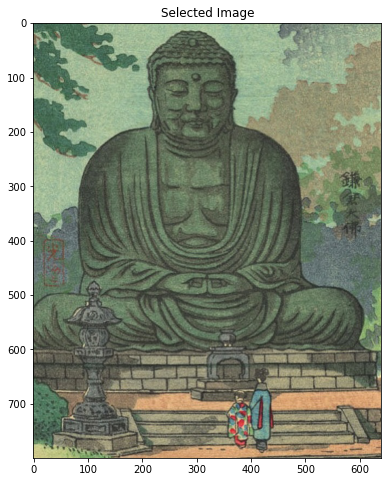

In [11]:
# Image Source: https://www.instagram.com/p/C50dGvWoKKF
img = im.imread("./img.jpg")
msg = np.reshape(img, (-1,))

fig, axis = plt.subplots(nrows= 1, ncols= 1, figsize= (8, 8))
axis.imshow(img)
axis.set_title("Selected Image")

**Encrypts the image**

In [12]:
cipher = []

for i in tqdm(range(len(msg))):
    
    # Select plaintext
    pixel = msg[i]
    
    # Map: pixel -> Point
    point = p2c[pixel]
    
    # Encrypt
    c = encrypt(point, public_key)
    
    # Save
    cipher.append(c)

100%|█████████████████████████████████████████████████████████████████████| 1536000/1536000 [00:33<00:00, 46356.65it/s]


**Displays the encrypted-image**

Text(0.5, 1.0, 'Encrypted Image')

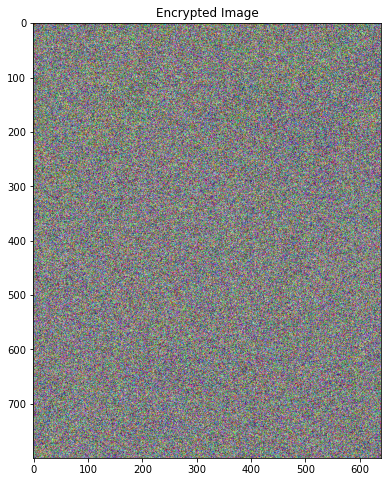

In [13]:
tmp = np.empty(msg.shape, dtype= np.int32)

for i, c in enumerate(cipher):
    tmp[i] = c2p[c[1]]

tmp = np.reshape(tmp, img.shape) / order

fig, axis = plt.subplots(nrows= 1, ncols= 1, figsize= (8, 8))
axis.imshow(tmp)
axis.set_title("Encrypted Image")

**Decrypts the image**

In [14]:
decipher = np.empty(msg.shape, dtype= np.uint8)

for i in tqdm(range(len(cipher))):
    
    # Decrypt
    d = decrypt(cipher[i], private_key)
    
    # Map: Point -> Pixel
    decipher[i] = c2p[d]

100%|██████████████████████████████████████████████████████████████████████| 1536000/1536000 [03:27<00:00, 7415.36it/s]


**Displays the decrypted-image**

Text(0.5, 1.0, 'Decrypted Image')

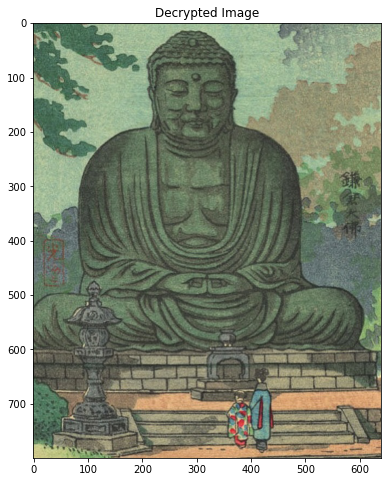

In [15]:
decipher = np.reshape(decipher, img.shape)

fig, axis = plt.subplots(nrows= 1, ncols= 1, figsize= (8, 8))
axis.imshow(decipher)
axis.set_title("Decrypted Image")